# Gambler's problem

Consider the following problem, introduced in Chapter 4 of the Sutton and Barto book.
A gambler is engaged in a betting game, where he must place bets on the outcomes of a sequence of coin
flips. Before each flip, the gambler decides how much to bet on the outcome that the coin will come up
heads—note that he can only decide how much to bet, not in which outcome to bet.
If the coin does come up heads, the gambler doubles the money bet on that coin flip—in other words,
if the gambler bets $5 dollars, he will get his $5 dollars back plus another $5 dollars. If the coin comes up
tails, the gambler loses the money he bet. The game goes on until either the gambler reaches his goal of
$100 dollars, or loses by running out of money. On each flip, the gambler must decide what portion of his
capital to stake, in integer numbers of dollars. Suppose that the probability of the coin coming up heads is
pH = 0.4.
You will analyze the optimal betting policy for the gambler. To do so, model the gambler’s decision
problem as an MDP, specifying the state and action spaces, the transition probabilities and the reward
function. Make sure to use a reward function that only rewards the gambler for reaching his goal. Use a
discount γ = 1.

**Question 2.** Using the MDP model for the gambler problem, run value iteration. Plot, in the
same plot, the computed estimate for the optimal value function at iterations 1, 2, 3 and final (stop your
algorithm when the overall error is smaller than 10−8). Can you provide an interpretation for the values
obtained? Plot also the optimal policy computed.
Note: The gambler problem is somewhat numerically unstable, so to compute the optimal policy make
sure to rounded up all values to 4 decimal places.

#### References
* Policy Iteration example (Jack’s Car Rental Problem): https://medium.com/@jaems33/this-is-start-of-my-exploration-into-learning-about-reinforcement-learning-d505a68a2d6
* Value Iteration example (Gambler’s Problem): https://medium.com/@jaems33/gamblers-problem-b4e91040e58a
* Value Iteration example (Grid): https://medium.com/@ngao7/markov-decision-process-value-iteration-2d161d50a6ff
* Gambler's Problem through Value Iteration and Policy Iteration: https://chisness.github.io/2020-01-14/policy-and-value-iteration-gambler-problem

### Markov Decision Process (MDP)
* State: Gambler's capital. S = {1,...,100}
* Policy: Mapping between gambler's capital to spend and how much it should bet.

In [129]:
import numpy as np
import matplotlib.pyplot as plt

In [130]:
GAMMA_DISCOUNT_FACTOR = 1 # discount
PROB_HEADS = 0.4 # probability of heads
GOAL = 100
MIN_STAKE = 1
MAX_STAKE = 99
ROUND = 4 # Ensure numerical stability to compute optimal policy

In [131]:
class ValueIterationGambler():
    prob_heads: float
    discount_factor: float
    capital_states: np.array # Contains values at each state 
    rewards: np.array # Reward function
    v: np.array
    converge_value: float
    goal: int

    def __init__(self, prob_heads: float, 
                 discount_factor: float,
                 min_stake: int,
                 max_stake: int, 
                 num_states: int) -> None:
        self.prob_heads = prob_heads # Transition probabilities
        self.discount_factor = discount_factor
        self.min_stake = min_stake
        self.max_stake = max_stake
        self.goal = num_states
        self.capital_states = np.zeros(num_states)
        self.rewards = np.zeros(num_states+1) # Add goal reward
        self.rewards[-1] = 1 # Reward of 1 when the gambler reaches the goal
        self.V = np.zeros(num_states+1) # Value function, when converging, should be the optimal value function
        self.converge_value = 1e-8

    def _bellman_equation(self, state: int, stake: int) -> float:
        """
        It calculates the value of an action at a state by computing the expected value
        of the immediate return from the action and the known value of the resulting state.
        
        Args:
            state: The gambler’s current state / capital.
            stake: The stake the gambler bets.
        
        Returns:
            The value of the state-action pair.
        """
        # If the coin comes tails, the gambler loses the stake, thus we subtract it from the current state
        tails = (1-self.prob_heads) * (self.rewards[state-stake] + self.discount_factor*self.V[state-stake])
        # If the coin comes heads, the gambler wins the stake, thus we sum it from the current state
        heads = self.prob_heads * (self.rewards[state+stake] + self.discount_factor*self.V[state+stake])
        # Add values of both possible outcomes
        return heads + tails

    def _choose_stake(self, state: int) -> tuple[int, int]:
        """
        Choose a stake to bet. In this context, it is equivalent to 
        choosing the best action by choosing the stake that maximizes
        the value function by using the recursive Bellman update,
        for a given state / capital.

        Args:
            state: The gambler’s current state / capital.
        
        Returns:
            A vector containing the expected value of each action. 
        """
        stakes = range(self.min_stake, min(state, self.goal-state)+1)
        expected_values = np.zeros(len(self.rewards))
        # For any given state, there exist many possible actions (stakes)
        # So we accumulate the expected values of each action and assign the value of the state to
        # that of the action that maximizes the value function
        for stake in stakes:
            # We are calculating the summation in the value iteration algorithm
            expected_values[stake] = self._bellman_equation(state, stake)
        return np.max(expected_values), np.argmax(expected_values)

    def run_iteration(self) -> tuple[int, list[int], list[np.array]]:
        """
        Value iteration algorithm described in Sutton Barto book Figure 4.5.
        Iterates until the value function converges.
        """
        iterations = [0, 1, 2]
        value_function_values = []
        iteration_count = 0
        while True:
            delta = 0
            for state in range(1, len(self.capital_states)+1):
                v, _ = self._choose_stake(state)
                # Comes before updating self.V[state] to use previous value
                delta = max(delta, np.abs(v - self.V[state]))    
                self.V[state] = v 
            if iteration_count in iterations:
                value_function_values.append(self.V.copy())  
            if delta < self.converge_value:
                print(f"Performed {iteration_count} iterations until convergence.")
                value_function_values.append(self.V.copy())
                iterations.append(iteration_count)
                break
            iteration_count += 1 
        return iteration_count, iterations, value_function_values

    def get_optimal_policy(self) -> np.array:
        """
        Returns:
            The optimal policy for the gambler using the optimal value function.
            In value iteration, we do not need to keep track of the policy at each iteration.
            We go from value function to value function, until we have the optimal value function.
            When we have the optimal value function, we know we have the optimal policy.
        """
        # Ensure numerical stability
        self.V = np.round(self.V, ROUND)
        policy = np.zeros(self.goal)
        for state in range(1, self.goal):
            _, policy[state] = self._choose_stake(state)
        return policy


In [132]:
gambler = ValueIterationGambler(PROB_HEADS, 
                                GAMMA_DISCOUNT_FACTOR,
                                MIN_STAKE,
                                MAX_STAKE, 
                                GOAL)
iteration_count, iterations, value_function_values = gambler.run_iteration()
optimal_policy = gambler.get_optimal_policy()

Performed 14 iterations until convergence.


[0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.4      0.4      0.4      0.4      0.4      0.4
 0.4      0.4      0.4      0.4      0.4      0.4      0.4      0.4
 0.4      0.4      0.4      0.4      0.4      0.4      0.4      0.4
 0.4      0.4      0.4      0.64     0.64     0.64     0.64     0.64
 0.64     0.64     0.64     0.64     0.64     0.64     0.64     0.64
 0.784    0.784    0.784    0.784    0.784    0.784    0.8704   0.8704
 0.8704   0.92224  0.92224  0.953344]
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.    

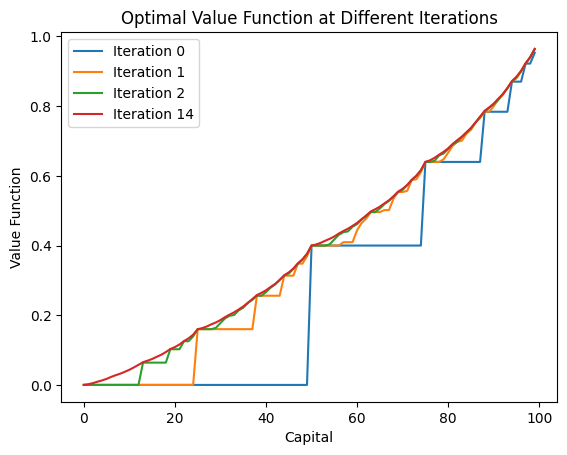

In [133]:
for iteration, value_function in zip(iterations, value_function_values):
    #print(value_function[:-1])
    plt.plot(value_function[:-1], label=f"Iteration {iteration}")
plt.title("Optimal Value Function at Different Iterations")
plt.xlabel("Capital")
plt.ylabel("Value Function")
plt.legend()
plt.show()

* In the first iteration, the value function is initialized with zeros for all states. As the iteration progresses, the values start to change. However, since it's the first iteration, the gambler has not yet refined its estimates, and the values are relatively uniform, which the exception to points where the gambler can easily win the game with prob_heads.
* In the second iteration, the value function starts showing higher values in states like 25 capital, where the gambler can also get closer to beating the game. More states show increases in the value function, in particular when the gambler is closer to the goal.
* In the third iteration, the trend is already quite close to the optimal value function, which is expected since as we get closer to the optimal value function, the improvements get smaller and smaller.
* The final iteration shows the optimal value function, which provides the maximum expected cumulative reward for each state.

In [134]:
print(f"Optimal Policy: {optimal_policy}")
print(f"Optimal Value Function: {gambler.V}")

Optimal Policy: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 12. 14. 10.  9.  8.
  7. 19. 20.  4. 22.  2.  1. 25. 24.  2. 22. 21. 20. 19.  7. 17. 16. 15.
 14. 12. 12. 39. 10. 41. 42. 43.  6. 45. 46. 47. 48.  1. 50. 49.  2. 47.
 46. 45. 44.  7. 42.  9. 40. 39. 12. 37. 14. 10. 16. 17. 18.  6. 20. 21.
 22. 23.  1. 25.  1. 23.  3.  4.  5. 19.  7.  8.  9. 10. 11. 12. 12. 11.
 10.  9.  8.  7.  6.  5.  4.  3.  2.  1.]
Optimal Value Function: [0.     0.0021 0.0052 0.0092 0.0129 0.0174 0.0231 0.0278 0.0323 0.0377
 0.0435 0.0504 0.0577 0.0652 0.0695 0.0744 0.0807 0.0866 0.0942 0.1031
 0.1087 0.116  0.1259 0.1336 0.1441 0.16   0.1631 0.1677 0.1738 0.1794
 0.1861 0.1946 0.2017 0.2084 0.2165 0.2252 0.2355 0.2465 0.2579 0.2643
 0.2716 0.281  0.2899 0.3013 0.3147 0.323  0.3339 0.3488 0.3604 0.3762
 0.4    0.4031 0.4077 0.4138 0.4194 0.4261 0.4346 0.4417 0.4484 0.4565
 0.4652 0.4755 0.4865 0.4979 0.5043 0.5116 0.521  0.5299 0.5413 0.5547
 0.563  0.5739 0.5888 0.6004 0.6162 0.64   0.6446 0.6516

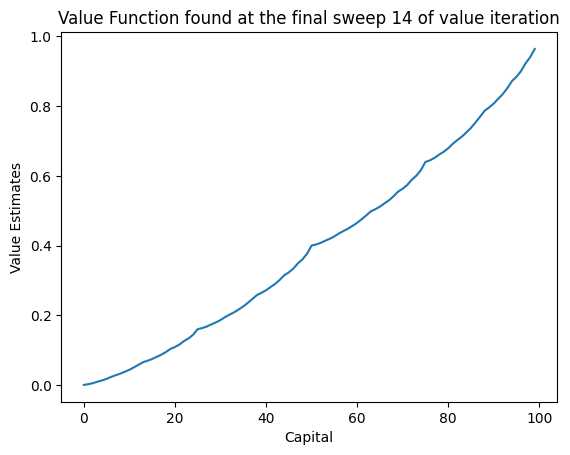

In [135]:
x = range(0, len(gambler.V)-1)
plt.plot(x, gambler.V[:-1])
plt.xlabel('Capital')
plt.ylabel('Value Estimates')
plt.title(f'Value Function found at the final sweep {iteration_count} of value iteration')
plt.show()

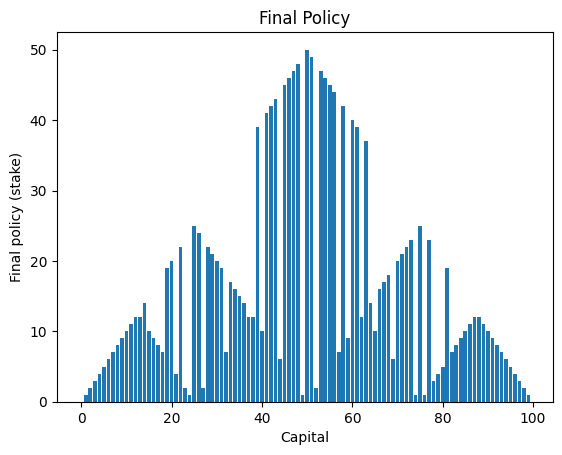

In [136]:
plt.bar(x, optimal_policy, align='center')
plt.xlabel('Capital')
plt.ylabel('Final policy (stake)')
plt.title('Final Policy')
plt.show()

* The final policy plot details how much the gambler should stake with a given current capital value. There are two smaller spikes at 25 and 75, and the largest one at 50. If we are at state 50, we have 40% chance of winning by betting all 50, while if we bet only 1 each time, we would need to win 50 times in a row, which is very unlikely. When we are at 25, we should bet 25 to try to reach 50 capital, since this would only require me to win twice in a row to beat the game. With capital 75, we would only need to bet 25 and win once to beat the game. However, if I have between 25 and 50, I can never beat the game in less than two rounds, and since I have a little more capital than 25, I can bet less. When I have more than 75, I also shouldn't risk more money than what is required to beat the game, thus the stakes should also be smaller than 75. If I have between 51 and 74, I don't want to risk getting much worse than 50 capital, since if I get to 75, I can already bet freely, knowing that I'll either get to around 50 or win the game.
* What this means is, since the odds are against us, we should try to beat the game with as few rounds as possible, and bet more when we are at an advantageous position (have more capital). 
* If prob_heads > 0.5, the odds would be in our favour, so we wouldn't need to bet more when we are at an advantageous positions, we could just bet 1 every time, and eventually, we would beat the game.

**NOTE:** The plot is quite different from the one presented in the book, which can be influenced by numerous factors, such as the precisions used, the discount factor gamma, and the precision of the converge value (number of iterations).